In [1]:
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib as mpl
from scipy.stats import mode

In [2]:
# input  
#
#
#
#
#
#

In [3]:
# import score data
raw_df = pd.read_csv('cleaned_urx_data.csv')

In [4]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

dbname = 'urx'
username = 'noahburbank'

engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))

In [5]:
# import worker data 
# connect:
con = None
con = psycopg2.connect(database = dbname, user = username)

# query:
sql_query = """
SELECT * FROM worker_table;
"""
workers = pd.read_sql_query(sql_query,con)

# query2:
sql_query2 = """
SELECT * FROM country_table;
"""
countries = pd.read_sql_query(sql_query2,con)

print workers.columns
print 
print countries.columns

Index([u'index', u'_worker_id', u'too_many_jobs', u'too_little_variance',
       u'unreasonable_mean', u'suspicious_timestamps', u'_trust',
       u'agg_score'],
      dtype='object')

Index([u'index', u'_country', u'jobs_count', u'mean_trust', u'median_trust',
       u'percent_minority_judgments', u'is_bad'],
      dtype='object')


In [6]:
# identify humans vs. robots 
humans = workers['agg_score'].apply(lambda x: x < 2)
robots = 1-humans
human_ids = workers['_worker_id'][humans]
robot_ids = workers['_worker_id'][robots]
print "there are " + str(sum(robots)) + " out of " + str(len(robots)) + " total workers"

there are 12 out of 80 total workers


In [7]:
# remove the scores attributable to robots 
human_rows = raw_df['_worker_id'].apply(lambda x: x in set(human_ids))
humans_only = raw_df[human_rows]

print "this eliminates " + str(len(raw_df) - len(humans_only)) + " out of " + str(len(raw_df)) + " original scores"

this eliminates 2831 out of 9058 original scores


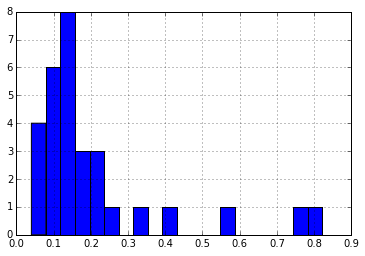

In [10]:
# see the corresponde of low trust and minority judgments 
country_df = countries
country_df['percent_minority_judgments'].hist(bins = 20)

minority_judgments = country_df['percent_minority_judgments']

## remove the contradictory countries: 

mu = np.mean(minority_judgments)
z = 1.96
other_part = (mu)*(1-mu)/len(minority_judgments)
other_part = other_part ** .5
low_ci_val = mu - z*other_part
high_ci_val = mu + z*other_part

# th is totally wrong, but let's just use the high ci for a normal distribution for 95% confidence and see where that goes


bad_countries = []
for country in country_df['_country']:
    is_bad = float(country_df['percent_minority_judgments'][country_df['_country'] == country])  > high_ci_val
    bad_countries.append(int(is_bad))
country_df['is_bad'] = bad_countries

In [11]:
country_df = countries
good_countries = []
for line in raw_df.iterrows():
    country_val = int(line[1]['_country'] in set(country_df[country_df['is_bad'] != 1]['_country']))
    good_countries.append(country_val)

In [12]:
# make the big changes 
temp_df = raw_df
temp_df['good_country'] = good_countries
good_countries_only = temp_df[raw_df['good_country'] == 1]


# output the conclusiosn of what's going on here 
print "there are " + str(sum(country_df['is_bad'])) + " bad countries" 
print "with over " + str(round(high_ci_val * 100,2)) + " percent judgments going against the majority/plurality"

missed_judgments = len(raw_df) - len(good_countries_only)
total_judgments = len(raw_df)
percent_lost = float(missed_judgments) / total_judgments

print 
print "eliminating them eliminates " + str(missed_judgments) + ' out of ' + str(total_judgments) + " judgments"
print "which is " + str(round(percent_lost  * 100, 2)) + '% of the judgments '
print 
print "there are now only " + str(len(good_countries_only)) + " judgments in the dataset"

fewest_judgments = good_countries_only.groupby('_unit_id')['please_make_your_relevancy_judgment'].count().min()

print 
print 'the worst covered unit pair contains only ' + str(fewest_judgments) + " judgments"

there are 4 bad countries
with over 35.96 percent judgments going against the majority/plurality

eliminating them eliminates 1328 out of 9058 judgments
which is 14.66% of the judgments 

there are now only 7730 judgments in the dataset

the worst covered unit pair contains only 5 judgments


In [13]:
raw_df = humans_only
country_df = countries
good_countries = []
for line in raw_df.iterrows():
    country_val = int(line[1]['_country'] in set(country_df[country_df['is_bad'] != 1]['_country']))
    good_countries.append(country_val)

# apply the no bad countries to the no robots set and see how different 
raw_df = humans_only
temp_df['good_country'] = good_countries
good_countries_only = temp_df[raw_df['good_country'] == 1]


# output the conclusiosn of what's going on here 
print "there are " + str(sum(country_df['is_bad'])) + " bad countries" 
print "with over " + str(round(high_ci_val * 100,2)) + " percent judgments going against the majority/plurality"

missed_judgments = len(raw_df) - len(good_countries_only)
total_judgments = len(raw_df)
percent_lost = float(missed_judgments) / total_judgments

print 
print "eliminating them eliminates " + str(missed_judgments) + ' out of ' + str(total_judgments) + " judgments"
print "which is " + str(round(percent_lost  * 100, 2)) + '% of the judgments '
print 
print "there are now only " + str(len(good_countries_only)) + " judgments in the dataset"

fewest_judgments = good_countries_only.groupby('_unit_id')['please_make_your_relevancy_judgment'].count().min()

print 
print 'the worst covered unit pair contains only ' + str(fewest_judgments) + " judgments"

ValueError: Length of values does not match length of index

In [ ]:
#
# there is negiligible difference between removing the robots and removing the countries that the robots comes from
#


In [ ]:
## normalize
##

def normalize(list_of_numbers):
    min_value = min(list_of_numbers)
    list_less_min = list_of_numbers - min_value
    max_value = max(list_less_min)
    normalized_values = list_less_min / max_value
    return normalized_values

In [ ]:
# get the unit ides for the key for the data frame
unit_ids = []
mean_scores_list = []
mode_scores_list = []

for group in raw_df.groupby('_unit_id')['please_make_your_relevancy_judgment']:
    unit_ids.append(group[0])
    mean_scores_list.append(np.mean(group[1]))
    

unit_id_scores = pd.DataFrame()
unit_id_scores['_unit_id'] = unit_ids
unit_id_scores['mean_score'] = mean_scores_list
unit_id_scores['normalized_mean_score'] = normalize(mean_scores_list)

unit_id_scores['normalized_mean_score'].hist(bins = 30)
cutoff_value = unit_id_scores.median()['normalized_mean_score']

unit_id_scores['rounded_normalized_mean_scores'] =  unit_id_scores['normalized_mean_score'].apply(lambda x: x > int(cutoff_value))

In [ ]:
# trust weighted average !!!!
trust_weighted_mean = dict()

for line in humans_only.groupby('_unit_id'):
    total_trust = line[1]['_trust'].sum()
    ind_trust_vector = line[1]['_trust']
    ind_judgment_vector = line[1]['please_make_your_relevancy_judgment']
    trust_mean = (ind_trust_vector * ind_judgment_vector).mean()
    trust_weighted_mean[line[0]] = trust_mean

normalized_trust_weighted_mean = normalize(trust_weighted_mean.values())
unit_id_scores['normalized_trust_weighted_mean'] = normalized_trust_weighted_mean
unit_id_scores['trust_weighted_mean'] = trust_weighted_mean

In [ ]:
pd.Series(data=normalized_trust_weighted_mean).hist(bins=30)

In [9]:
unit_id_scores['normalized_mean_score'].hist(bins = 50, figsize= (20,10))
unit_id_scores['mean_score'].hist(bins = 50)

NameError: name 'unit_id_scores' is not defined

In [71]:
# output to unit pair scores table
#
#
#
#
#
#
#
#
# put this into the database, so that i don't need to process it each time, 
#becuase it is very slow
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

dbname = 'urx'
username = 'noahburbank'

engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))

In [ ]:
unit_id_scores.to_sql('scores', engine, if_exists = 'replace')